<a href="https://colab.research.google.com/github/FedericoRaschiatore0123/GATr_Deep_Learning_Project/blob/main/GATr_deep_learning_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [1]:
!git clone https://github.com/FedericoRaschiatore0123/GATr_Deep_Learning_Project.git

Cloning into 'GATr_Deep_Learning_Project'...
remote: Enumerating objects: 4270, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 4270 (delta 116), reused 141 (delta 108), pack-reused 4120
Receiving objects: 100% (4270/4270), 1.70 GiB | 19.84 MiB/s, done.
Resolving deltas: 100% (187/187), done.
Updating files: 100% (4006/4006), done.


In [2]:
#librerie
!pip install pytorch_lightning --quiet
!pip install h5py
!pip install trimesh
!pip install torch_geometric
!pip install pyquaternion
!pip install clifford
!pip install einops

from torchmetrics.classification import BinaryAccuracy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch_geometric.data
from torch_geometric.data import Data
from torch.utils.data import random_split, ConcatDataset, Subset
from pyquaternion import Quaternion
import clifford as cf
import pytorch_lightning as pl
import math
from einops import rearrange

import h5py
import os
import trimesh
import random

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.2/802.2 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.9/693.9 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.3/159.3 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.3 MB/s eta 0:00:00


#Global Variables

In [3]:
# create a dictionary of global variables
global_variables = {

    'single_path' : '/content/GATr_Deep_Learning_Project/single/',
    'bifurcating_path' : '/content/GATr_Deep_Learning_Project/bifurcating/',

    'length_data' : 100,
    'mv_dimension' : 16,
    'mv_channels' :4,
    'hidden_dim_mv' : 8,
    'num_heads' : 4,
    'out_channels' : 1,
    'num_classes' : 2,


    'batch_size' :  32,
    'num_workers' : 2,

    'dim_GA' : 16,
    'hidden_dim' : 8,

    'geometric_guidance' : '/content/GATr_Deep_Learning_Project/data/geometric_product.pt',
    'outer_guidance' : '/content/GATr_Deep_Learning_Project/data/outer_product.pt',
}

#Get device

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device('cpu')

#Show data

In [5]:
single_list = os.listdir(global_variables['single_path'])

with h5py.File(global_variables['single_path'] + single_list[random.randint(0, len(single_list))] , 'r') as file:

    vertices = np.array(file['pos'])
    faces = np.array(file['face'])

mesh = trimesh.Trimesh(vertices=vertices, faces=faces)
mesh.show()

In [6]:
bifurcating_list = os.listdir(global_variables['bifurcating_path'])

with h5py.File(global_variables['bifurcating_path'] + bifurcating_list[random.randint(0, len(bifurcating_list))] , 'r') as file:
    vertices = np.array(file['pos'])
    faces = np.array(file['face'])

mesh = trimesh.Trimesh(vertices=vertices, faces=faces)
mesh.show()

In [7]:
def check_balancing(dataset):
  label = []
  for _ , element in enumerate(dataset):
    label.append(element[-1])

  categories = ['Single ' +  str(label.count(0)), 'Bifurcating ' +  str(label.count(1))]

  fig, ax = plt.subplots(figsize = (8,5))

  bars = ax.bar(
      categories,
      [label.count(0), label.count(1)],
      align = 'center'
    )

  ax.set_xlabel('Labels')
  ax.set_ylabel('Number of occurences')

  plt.ylim(ymax = len(label))
  plt.show()

# Geometric Algebra

Geometric algebra G_{3,0,1} is characterized by 4 basic elements (e_{0}, e_{1}, e_{2}, e_{3}) that represent planes in the 3D space. These 4 basic elements can be combined through linear combination and geometric transformation to represent geometric objects of different dimensions (planes, lines, points), and transformations of different types (reflections, translations, rotations).

G_{3,0,1} indicates that the basis is composed by three elements (e_{1}, e_{2}, e_{3}) that satisfy e_{i}e_{i} = 1 and one (e_{0}) that satisfies e_{0}e_{0} = 0.

The basis components of the multivector associated to the G_{3,0,1} algebra are obtained by considering every possible multiplicative combination of the basis elements. Elements of different grade are thus obtained:

Grade 0 (1): scalars in the G.A. \\
Grade 1 (e_{0}, e_{i}): vectors in the G.A. \\
Grade 2 (e_{0i}, e_{ij}); bivectors in the G.A. \\
Grade 3 (e_{0ij}, e_{ijk}): trivectors in the G.A. \\
Grade 4 (e_{0123}): pseudoscalars in the G.A. \\

The multivector representation associated to the Geometric Algebra G_{3,0,1} will thus be composed of a total of 16 elements.

Scalars will be represented by grade 0 elements, planes by grade 1 elements, lines by grade 2 elements, points by grade 3 elements and pseudoscalar by grade 4 elements.

In [8]:
def embed_pos_mv_16(pos):
    """
    Embeds the pos torch tensor as a 16-dimensional G_{3,0,1} multivector

    Args:
        pos (torch.Tensor): tensor of input points with shape (n_elements, 3)

    Returns:
        pos_mv torch.Tensor: tensor of multivectors of dimension 16 with shape (1, n_elements, 1, 16)
    """
    # Positions in Euclidean geometry can be embedded as points in G_{3,0,1} algebra

    # Get the number of points and the dimensionality
    n_elements = pos.shape[0]
    dim = pos.shape[1]

    # Create multivector tensor
    multivector = torch.zeros(n_elements, global_variables['dim_GA'])

    multivector[:, 14] = 1 # homogeneous component, e_{123}
    multivector[:, 11] = pos[:, 0] # x, e_{023}
    multivector[:, 12] = pos[:, 1] # y, e_{013}
    multivector[:, 13] = pos[:, 2] # z, e_{012}

    pos_mv = multivector.reshape(1,n_elements,1,global_variables['dim_GA'])

    return pos_mv

In [9]:
def embed_face_mv_16(face):
    """
    Embeds the face torch tensor as a 16-dimensional G_{3,0,1} multivector

    Input:
        face torch.Tensor of size (n_elements, 3)
    Output:
        mv torch.Tensor of size (1, n_elements, 1, 16)
    """

    # An oriented surface in Euclidean geometry characterized by
    #   the normal vector n to the surface itself can be embedded as an oriented
    #   plane in G_{3,0,1} algebra


    # Get the number of points and the dimensionality of the space
    n_elements = face.shape[0]
    dim = face.shape[1]

    # Create multivector tensor
    multivector = torch.zeros(n_elements, global_variables['dim_GA'])

    multivector[:, 2] = face[:, 0] # e_{1}
    multivector[:, 3] = face[:, 1] # e_{2}
    multivector[:, 4] = face[:, 2] # e_{3}

    face_mv = multivector.reshape(1,n_elements,1,global_variables['dim_GA'])

    return face_mv

In [10]:
def embed_wss_mv_16(wss):
    """
    Embeds the wss vectors as a 16 dimensional G_{3,0,1} multivector
    Input:
      wss torch.Tensor of size (n_elements, 3)
    Output:
      wss_mv torch.Tensor of size (1, n_elements, 1, 16)
    """

    # A 3D vector in the Euclidean space can be embedded as a translation in G_{3,0,1} algebra

    n_elements = wss.shape[0]
    dim = wss.shape[1]

    multivector = torch.zeros(n_elements, global_variables['dim_GA'])

    multivector[:, 0] = 1
    multivector[:, 5] = 0.5*wss[:, 0] # e_{01}
    multivector[:, 6] = 0.5*wss[:, 1] # e_{02}
    multivector[:, 7] = 0.5*wss[:, 2] # e_{03}

    wss_mv = multivector.reshape(1,n_elements,1,global_variables['dim_GA'])

    return wss_mv

In [11]:
def embed_inlet_mv_16(inlet):
    """
    Embeds the inlet torch tensor as a 16 dimensional G_{3,0,1} multivector
    Input:
        inlet torch.Tensor of size (n_elements, 1)
    Output:
        inlet_mv torch.Tensor of size (1, n_elements, 1, 16)
    """
    # Inlet indexes can be embedded as scalars in G_{3,0,1} algebra

    n_elements = inlet.shape[0]

    multivector = torch.zeros(n_elements, global_variables['dim_GA'])
    multivector[:, 0] = inlet[:]

    inlet_mv = multivector.reshape(1, n_elements, 1, global_variables['dim_GA'])

    return inlet_mv

In [12]:
def embed_pressure_mv_16(pressure):
  """
  Embeds the pressure torch tensor as a 16-dimensional G_{3,0,1} multivector
  Input:
    pressure torch.Tensor of size (n_elements, 1)
  Output:
    pressure_mv torch.Tensor of size (1, n_elements, 1, 16)
  """

  n_elements = pressure.shape[0]

  # Initialize the multivector
  multivector = torch.zeros(n_elements, global_variables['dim_GA'])

  multivector[:,0] = pressure[:]
  pressure_mv = multivector.reshape(1, n_elements, 1, global_variables['dim_GA'])

  return pressure_mv

In [13]:
def embed_complete_mv_16(sample_path):
  """
  Embeds the artery sample into a concatenation of 5 16-dimensional multivectors in G_{3,0,1}.
  Each of the 5 multivectors embeds a different feature of the artery: pos, face, wss, inlet_idcs, pressure
  Input:
    sample_path: path to the artery sample saved in hdf5 format
  Output:
    sample_embedding: torch.Tensor of size (1, 50, 5, 16) NOTE: we chose to cut the sample at 50 !!!
  """

  with h5py.File(sample_path, 'r') as f:
    # extract torch tensor for pos
    pos_data = f['pos'][:global_variables['length_data']]
    pos_torch = torch.tensor(pos_data[:])
    pos_torch_norm = (pos_torch - torch.mean(pos_torch)) / torch.std(pos_torch)

    # extract torch tensor for face
    face_data = f['face'][:global_variables['length_data']]
    face_torch = torch.tensor(face_data[:])

    # extract torch tensor for wss
    wss_data = f['wss'][:global_variables['length_data']]
    wss_torch = torch.tensor(wss_data[:])
    wss_torch_norm = (wss_torch - torch.mean(wss_torch)) / torch.std(wss_torch)

    # extract torch tensor for pressure
    pressure_data = f['pressure'][:global_variables['length_data']]
    pressure_torch = torch.tensor(pressure_data[:])
    pressure_torch_norm = (pressure_torch - torch.mean(pressure_torch)) / torch.std(pressure_torch)

    # extract torch tensor for inlet_idcs
    #inlet_data = f['inlet_idcs'][:100]
    #inlet_torch = torch.tensor(inlet_data[:])

  # Get the multivector embeddings for each torch tensor
  pos_mv_16 = embed_pos_mv_16(pos_torch_norm)
  face_mv_16 = embed_face_mv_16(face_torch)
  wss_mv_16 = embed_wss_mv_16(wss_torch_norm)
  #inlet_mv_16 = embed_inlet_mv_16(inlet_torch)
  pressure_mv_16 = embed_pressure_mv_16(pressure_torch_norm)

  sample_embedding = torch.cat(
      [pos_mv_16, face_mv_16, wss_mv_16, pressure_mv_16], dim = 2) #we removed inlet indeces from the embedding

  return sample_embedding

In [14]:
# Use of embed_complete_mv_16

sample_path = "/content/GATr_Deep_Learning_Project/single/sample_0000.hdf5"
sample_embedding = embed_complete_mv_16(sample_path)
print(sample_embedding.shape)

torch.Size([1, 100, 4, 16])


## Geometric Algebra Transformations

In [15]:
def embed_plane_reflection_mv_16(normal, d):
  """
  Embeds a plane reflection transformation given a normal vector and an origin shift
  as a 16-dimensional multivector in G_{3,0,1}
  Input:
    normal: torch.Tensor (1, 3) normal to the plane
    d: origin shift
  Output:
    pr_mv_16: torch.Tensor multivector of size (1,1,1,16) representing the plane reflection
  """
  # Initialize the multivector
  plane_reflection_mv_16 = torch.zeros(1, global_variables['dim_GA'])

  plane_reflection_mv_16[0,1] = d
  plane_reflection_mv_16[0,2] = normal[0]
  plane_reflection_mv_16[0,3] = normal[1]
  plane_reflection_mv_16[0,4] = normal[2]

  pr_mv_16 = plane_reflection_mv_16.reshape(1,1,1,global_variables['dim_GA'])

  return pr_mv_16



In [16]:
def embed_translation_mv_16(t):
  """
  Embeds a translation by a vector t in R^{3} as a 16-dimensional multivector in G_{3,0,1}
  Input:
    t: torch.Tensor of size (1, 3) representing a translation in the 3D space
  Output:
    tr_mv_16: torch.Tensor multivector of size (1,1,1,16) representing the translation
  """
  # Initialize the multivector
  translation_mv_16 = torch.zeros(1, global_variables['dim_GA'])

  translation_mv_16[0,0] = 1 # homogeneous component
  translation_mv_16[0,5] = 0.5*t[0]
  translation_mv_16[0,6] = 0.5*t[1]
  translation_mv_16[0,7] = 0.5*t[2]

  tr_mv_16 = translation_mv_16.reshape(1,1,1,global_variables['dim_GA'])

  return tr_mv_16

In [17]:
def embed_point_reflection_mv(p):
  """
  Embeds a reflection with respect to a point p in R^{3} as a 16-dimensional multivector in G_{3,0,1}
  Input:
    p: torch.Tensor of size (1,3) representing a point in 3D
  Output:
    pt_ref_mv_16: torch.Tensor of size (1,1,1,16) representing the point reflection
  """
  # Initialize the multivector
  point_reflection_mv_16 = torch.zeros(1, global_variables['dim_GA'])

  point_reflection_mv_16[0,11] = p[0]
  point_reflection_mv_16[0,12] = p[1]
  point_reflection_mv_16[0,13] = p[2]
  point_reflection_mv_16[0,14] = 1

  # Reshape to match the shape of the other multivectors
  pt_ref_mv_16 = point_reflection_mv_16.reshape(1,1,1,global_variables['dim_GA'])

  return pt_ref_mv_16

In [18]:
def embed_quaternion_rotation_mv_16(rot_axis, alpha):
  """
  Embeds a rotation defined by a quaterion through the axis angle rotation representation
  Input:
    rot_axis: list of size 1x3 representing the axis of the rotation [r1,r2,r3]
    alpha: float representing the angle of the rotation
  Output:
    quat_rot_mv_16: torch.Tensor of size (1,1,1,16) representing a rotation quaternion rotation
  """
  quaternion = Quaternion(axis=rot_axis, angle=alpha)

  # Initialize the multivector
  quaternion_rotation_mv_16 = torch.zeros(1, global_variables['dim_GA'])

  quaternion_rotation_mv_16[0, 0] = quaternion.w
  quaternion_rotation_mv_16[0, 8] = quaternion.x
  quaternion_rotation_mv_16[0, 9] = quaternion.y
  quaternion_rotation_mv_16[0, 10] = quaternion.z

  quat_rot_mv_16 = quaternion_rotation_mv_16.reshape(1,1,1,global_variables['dim_GA'])

  return quat_rot_mv_16

#Blades

In [19]:
def extract_blades(mv, layout):
    # mv: torch.Tensor [1, 16]
    cf_mv = layout.MultiVector(mv.numpy())

    w_blade_array = []
    v_blade_array = []
    blade_array = []

    grades = len(cf_mv.grades())

    for grade in range(grades):
        # elements of w_{k} (5 elements)
        cf_w_blade = cf_mv(grade)  # mv in clifford
        coeffs = list(cf_w_blade.value)
        blade_torch = torch.tensor(coeffs)
        w_blade_array.append(blade_torch)

    for grade in range(grades-1):  # end at num_blades-1
        # elements of v_k (4 elements)
        cf_blade = cf_mv(grade)
        cf_v_blade = e0^cf_blade  # Use the geometric product to extract v-blades
        coeffs = list(cf_v_blade.value)
        blade_torch = torch.tensor(coeffs)
        v_blade_array.append(blade_torch)

    return torch.stack(w_blade_array + v_blade_array)

In [20]:
def blade_matrices(blades):
  matrices = []
  for _, blade in enumerate(blades):

    matrix = torch.zeros((16, 16))
    for i, element in enumerate(blade):
      if element.int() != 0:
        matrix[i][element.int()-1] = 1
    matrices.append(matrix)

  return torch.stack(matrices)


# Operations between multivectors
- Inner product \\
- Outer product \\
- Geometric product \\

These are calculated using the functions defined in the library Clifford. First, we create an instance of the geometric algebra using clifford. Then, in the three functions defined below, we convert the torch multivectors into clifford multivectors,
we calculate the operation of interest and finally express the result back into torch.Tensor format.

In [21]:
# instantiate clifford G_{3,0,1} algebra
layout, blades = cf.Cl(p=3, q=0, r=1, firstIdx=0)
locals().update(blades)

print('PGA blades: ', blades)
print('PGA layout: ', layout)

PGA blades:  {'': 1, 'e0': (1^e0), 'e1': (1^e1), 'e2': (1^e2), 'e3': (1^e3), 'e01': (1^e01), 'e02': (1^e02), 'e03': (1^e03), 'e12': (1^e12), 'e13': (1^e13), 'e23': (1^e23), 'e012': (1^e012), 'e013': (1^e013), 'e023': (1^e023), 'e123': (1^e123), 'e0123': (1^e0123)}
PGA layout:  Layout([0, 1, 1, 1], ids=BasisVectorIds.ordered_integers(4, first_index=0), order=BasisBladeOrder.shortlex(4), names=['', 'e0', 'e1', 'e2', 'e3', 'e01', 'e02', 'e03', 'e12', 'e13', 'e23', 'e012', 'e013', 'e023', 'e123', 'e0123'])


In [22]:
def get_mask_product():

    """
    Returns a torch.Tensor [16]: mask that contains 0 if the corresponding multivector blade contains 0, 1 otherwise
    """
    mv = torch.ones(16)
    cf_mv = layout.MultiVector(mv.numpy())
    prod = e0^cf_mv
    coeffs = list(prod.value)
    mask_complement = torch.Tensor(coeffs)
    mask = 1- mask_complement

    return mask

In [23]:
def inner_product(x, y):
    """Computes the inner product of multivectors f(x,y) = <x, y> = <~x y>_0.

    Sums over the 16 multivector dimensions.

    Equal to `geometric_product(reverse(x), y)[..., [0]]` (but faster).

    Parameters
    ----------
    x : torch.Tensor with shape (..., 16) or (..., channels, 16)
        First input multivector. Batch dimensions must be broadcastable between x and y.
    y : torch.Tensor with shape (..., 16) or (..., channels, 16)
        Second input multivector. Batch dimensions must be broadcastable between x and y.

    Returns
    -------
    outputs : torch.Tensor with shape (..., 1)
        Result. Batch dimensions are result of broadcasting between x and y.
    """

    guidance = torch.load(global_variables['geometric_guidance']).to_dense()

    reversal_index = torch.ones(16)[5:15] = -1

    inner_product_mask = (torch.diag(guidance[0]) * reversal_index).bool()

    selector = torch.arange(16)[inner_product_mask]

    x = x[..., selector]
    y = y[..., selector]

    outputs = torch.einsum(
        "... i, ... i -> ...",
        x,
        y
    )

    # We want the output to have shape (..., 1)
    outputs = outputs.unsqueeze(-1)

    return outputs

In [24]:
def outer_product(x, y):
    """Computes the outer product `f(x,y) = x ^ y`.

    Parameters
    x : torch.Tensor with shape (..., 16)
        First input multivector. Batch dimensions must be broadcastable between x and y.
    y : torch.Tensor with shape (..., 16)
        Second input multivector. Batch dimensions must be broadcastable between x and y.

    Returns
    -------
    outputs : torch.Tensor with shape (..., 16)
        Result. Batch dimensions are result of broadcasting between x, y, and coeffs.
    """

    guidance = torch.load(global_variables['outer_guidance']).to_dense()

    outputs = torch.einsum(
        "i j k, ... j, ... k -> ... i",
        guidance.float(),
        x,
        y
    )

    return outputs

In [25]:
def geometric_product(x, y):
    """Computes the geometric product f(x,y) = xy.

    Parameters
    ----------
    x : torch.Tensor with shape (..., 16)
        First input multivector. Batch dimensions must be broadcastable between x and y.
    y : torch.Tensor with shape (..., 16)
        Second input multivector. Batch dimensions must be broadcastable between x and y.

    Returns
    -------
    outputs : torch.Tensor with shape (..., 16)
        Result. Batch dimensions are result of broadcasting between x, y, and coeffs.
    """

    # Select kernel on correct device
    guidance = torch.load(global_variables['geometric_guidance']).to_dense()

    # Compute geometric product
    outputs =  torch.einsum(
        "i j k, ... j, ... k -> ... i",
        guidance.float(),
        x,
        y
    )

    return outputs

In [26]:
def dualize_mv(mv):

  '''
  mv: torch.tensor of size [1, 16]
  returns the dualized multivector
  '''

  dualization_map = torch.zeros([16, 16])
  for i in range(16):
    dualization_map[i, 16-1-i] = 1

  dualized_mv = torch.matmul(mv, dualization_map)

  return dualized_mv

In [27]:
# join operation
def join_operation(mv_1, mv_2):
  mv_1_dual = dualize_mv(mv_1)
  mv_2_dual = dualize_mv(mv_2)
  outer_prod = outer_product(mv_1_dual, mv_2_dual)
  print(outer_prod.shape)
  joined_mv = dualize_mv(outer_prod)

  return joined_mv


In [28]:
# example of use of the functions above:
mv_1 = torch.Tensor([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
mv_2 = torch.Tensor([16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1])

geometric_prod_mv = geometric_product(mv_1,mv_2)
print('multivector 1: ', mv_1)
print('multivector 2: ', mv_2)
print('geometric product mv_1*mv_2: ', geometric_prod_mv)

multivector 1:  tensor([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
        15., 16.])
multivector 2:  tensor([16., 15., 14., 13., 12., 11., 10.,  9.,  8.,  7.,  6.,  5.,  4.,  3.,
         2.,  1.])
geometric product mv_1*mv_2:  tensor([ -68., -206.,  120.,  202., -284.,  420.,  176., -524.,  342., -104.,
         398.,  444.,  228.,  500.,  404.,  342.])


#Dataset

In [29]:
class DataModule(pl.LightningDataModule):
  def __init__(self, path_single, path_bifurcating):
    super(DataModule,self).__init__()

    self.single_data_path = path_single
    self.bifurcating_data_path = path_bifurcating
    self.dataset = None

  def prepare_data(self):

    single_dataset, label_single = self.load_data(self.single_data_path,  bifurcating=False)
    bifurcating_dataset, label_bifurcating = self.load_data(self.bifurcating_data_path,  bifurcating=True)
    indices = torch.randperm(label_single.shape[0] + label_bifurcating.shape[0])

    self.dataset = self.shuffle_and_combine_datasets(single_dataset, bifurcating_dataset, indices)
    self.label = self.shuffle_and_combine_datasets(label_single, label_bifurcating, indices)

  def setup(self, stage=None):

    train, validation, test = self.split_dataset(list(zip(self.dataset, self.label)))

    if stage == "fit" or stage is None:
      self.train_dataset = train
      self.validation_dataset = validation

    if stage == "test" or stage is None:
      self.test_dataset = test

  def load_data(self, path, bifurcating=False):
    data = []
    for file in os.listdir(path):
        data.append(embed_complete_mv_16(path + file))

    label = torch.ones(len(data)) if bifurcating else torch.zeros(len(data))
    data = torch.stack(data).squeeze()

    return data , label


  def shuffle_and_combine_datasets(self, dataset1, dataset2, indices):

      combined_dataset = ConcatDataset([dataset1, dataset2])
      shuffled_dataset = Subset(combined_dataset, indices)

      return shuffled_dataset

  def split_dataset(self, dataset, train_ratio=0.7, validation_ratio=0.2, test_ratio=0.1):

      total_size = len(dataset)
      train_size = int(total_size * train_ratio)
      validation_size = int(total_size * validation_ratio)
      test_size = total_size - train_size - validation_size

      train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])

      return train_dataset, validation_dataset, test_dataset

  def train_dataloader(self):
      return DataLoader(
          self.train_dataset,
          shuffle = True,
          batch_size = global_variables['batch_size'],
          num_workers = global_variables['num_workers']
        )

  def val_dataloader(self):
      return DataLoader(
          self.validation_dataset,
          shuffle = False,
          batch_size = global_variables['batch_size'],
          num_workers = global_variables['num_workers']
        )

  def test_dataloader(self):
      return DataLoader(
          self.test_dataset,
          shuffle = False,
          batch_size = global_variables['batch_size'],
          num_workers = global_variables['num_workers']
        )

  def train_dataset(self):
    return self.train_dataset

  def val_dataset(self):
    return self.val_dataset

  def test_dataset(self):
    return self.test_dataset

In [30]:
data_module_prove = DataModule(global_variables['single_path'], global_variables['bifurcating_path'])

data_module_prove.prepare_data()
data_module_prove.setup(stage="fit")
train_dataloader = data_module_prove.train_dataloader()

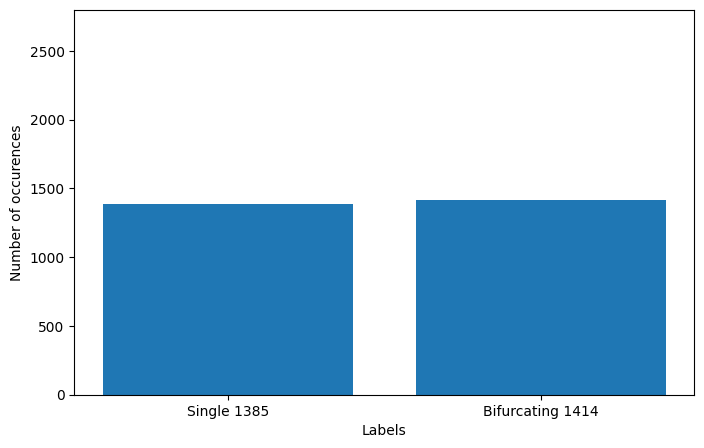

In [31]:
check_balancing(data_module_prove.train_dataset)

#Transformer

<center>

![Baseline](https://drive.google.com/uc?export=download&id=1gg8ec3XNFPuOmF4RM_eJpmflVb9NDwFq)

</center>

In [32]:
class MultiHeadAttention(nn.Module):
    def __init__(self, hidden_dim, num_heads, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        assert hidden_dim % num_heads == 0, "emb_dim must be divisible by num_heads"

        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.head_dim = hidden_dim // num_heads

        self.query = nn.Linear(self.head_dim, self.head_dim)
        self.key = nn.Linear(self.head_dim, self.head_dim)
        self.value = nn.Linear(self.head_dim, self.head_dim)

    def forward(self, x):

        x = x.view(x.shape[0], x.shape[1], self.num_heads, self.head_dim).transpose( 1, 2 )

        q = self.query(x)
        k = self.key(x)
        v = self.value(x)

        att = self.att_score(q, k, v)

        out = att.transpose(1, 2).reshape(x.shape[0], x.shape[2], self.hidden_dim)

        return out

    def att_score(self, q, k, v):
        attn_scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)

        attn_probs = torch.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_probs, v)
        return output


In [33]:
class Encoder(nn.Module):
  def __init__(self, input_dim, hidden_dim, num_heads, dropout = 0.1):
    super(Encoder, self).__init__()

    self.multi_head_attention = MultiHeadAttention(hidden_dim, num_heads)

    self.feedforward = nn.Sequential(
        nn.Linear(hidden_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim)
    )

    self.layer_norm1 = nn.LayerNorm(hidden_dim)
    self.layer_norm2 = nn.LayerNorm(hidden_dim)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):

    att = self.multi_head_attention(x)

    norm = self.layer_norm1( x + self.dropout(att))

    ff = self.feedforward(norm)

    out = self.layer_norm2( norm + self.dropout(ff))

    return out

In [75]:
class Transformer(nn.Module):
  def __init__(self, input_dim, channels, hidden_dim, num_heads, out_channels, number_of_samples, number_of_classes, dropout = 0.1):
    super(Transformer, self).__init__()

    self.input_dim = input_dim
    self.channels = channels

    self.input_embedding = nn.Sequential(
        nn.Linear(input_dim * channels, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim)
    )

    self.ff_layer1 = nn.Linear(hidden_dim, out_channels)
    self.relu = nn.ReLU()
    self.ff_layer2 = nn.Linear(number_of_samples, number_of_classes - 1)

    self.encoder = Encoder(input_dim, hidden_dim, num_heads, dropout)

    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = x.reshape(x.shape[0], x.shape[1], x.shape[2]* x.shape[3])

    x = self.input_embedding(x)

    x = self.encoder(x)

    x = self.ff_layer1(x)
    x = self.relu(x)
    x = x.squeeze()

    x = self.ff_layer2(x)

    return self.sigmoid(x).squeeze()

In [76]:
class TransformerPL(pl.LightningModule):
  def __init__(self, input_dim, channels, hidden_dim, num_heads, out_dim, number_of_samples, number_of_classes, dropout = 0.1, lr=1e-3):
    super(TransformerPL, self).__init__()

    self.transformer = Transformer(
        input_dim,
        channels,
        hidden_dim,
        num_heads,
        out_dim,
        number_of_samples,
        number_of_classes,
        dropout,
    )

    self.lr = lr

    self.criterion = nn.BCELoss()

    self.accuracy = BinaryAccuracy()

  def forward(self, x):
    return self.transformer(x)

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
    #scheduler
    return optimizer

  def training_step(self, batch):
    input, label = batch

    outputs = self.transformer(input)
    print(outputs)
    loss = self.criterion(outputs, label.float())
    self.log("train_loss", loss)
    print("train_loss", loss)
    return loss

  def validation_step(self, batch):
    input, label = batch

    outputs = self.transformer(input)
    loss = self.criterion(outputs, label.float())

    acc = self.accuracy(outputs, label)
    output_values = {"val_loss": loss, "val_acc" : acc}
    self.log_dict(output_values)
    return loss

  def test_step(self, batch):
    input, label = batch

    outputs = self.transformer(input)
    loss = self.criterion(outputs, label.float())
    acc = self.accuracy(outputs, label)

    output_values = {"test_loss": loss, "test_acc" : acc}
    self.log_dict(output_values)
    return loss

##Train

In [77]:
transformer_data_module = DataModule(
        global_variables['single_path'],
        global_variables['bifurcating_path']
    )

transformer = TransformerPL(
        global_variables['mv_dimension'],
        global_variables['mv_channels'],
        global_variables['hidden_dim_mv'],
        global_variables['num_heads'],
        global_variables['out_channels'],
        global_variables['length_data'],
        global_variables['num_classes']
    )

trainer = pl.Trainer(max_epochs = 5)

trainer.fit(transformer, transformer_data_module)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type           | Params
-----------------------------------------------
0 | transformer | Transformer    | 896   
1 | criterion   | BCELoss        | 0     
2 | accuracy    | BinaryAccuracy | 0     
-----------------------------------------------
896       Trainable params
0         Non-trainable params
896       Total params
0.004     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

tensor([0.4853, 0.4732, 0.4531, 0.4770, 0.4971, 0.4900, 0.4646, 0.4751, 0.4792,
        0.4652, 0.4947, 0.4646, 0.4772, 0.4800, 0.4711, 0.4658, 0.4578, 0.4879,
        0.4570, 0.4928, 0.4793, 0.4755, 0.4728, 0.4720, 0.4769, 0.4786, 0.4632,
        0.4845, 0.4910, 0.4839, 0.4944, 0.4778], grad_fn=<SqueezeBackward0>)
train_loss tensor(0.6940, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([0.4966, 0.4874, 0.4617, 0.4752, 0.4645, 0.4466, 0.4903, 0.4894, 0.4817,
        0.4782, 0.4736, 0.4840, 0.4877, 0.4759, 0.4824, 0.4590, 0.4725, 0.4744,
        0.4881, 0.4711, 0.4826, 0.4776, 0.4856, 0.4833, 0.4687, 0.4874, 0.4849,
        0.4682, 0.4883, 0.4721, 0.4785, 0.4767], grad_fn=<SqueezeBackward0>)
train_loss tensor(0.7133, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([0.4895, 0.4802, 0.4790, 0.4555, 0.4777, 0.4737, 0.4792, 0.4546, 0.4745,
        0.4743, 0.4847, 0.4787, 0.4832, 0.4927, 0.4863, 0.4860, 0.4772, 0.4764,
        0.4794, 0.4953, 0.4797, 0.4661, 0.5082, 0.4852, 0.4761, 0.4838, 0.48

Validation: |          | 0/? [00:00<?, ?it/s]

tensor([0.9845, 0.9820, 0.4825, 0.9854, 0.4870, 0.4863, 0.9895, 0.4870, 0.9894,
        0.9870, 0.9937, 0.9882, 0.9853, 0.4870, 0.4854, 0.9860, 0.9902, 0.9074,
        0.8242, 0.9780, 0.4870, 0.4870, 0.9824, 0.4870, 0.9877, 0.4870, 0.9692,
        0.4806, 0.4854, 0.4870, 0.4868, 0.9916], grad_fn=<SqueezeBackward0>)
train_loss tensor(0.3557, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([0.4867, 0.4867, 0.9753, 0.4865, 0.6026, 0.7990, 0.4867, 0.9914, 0.4829,
        0.9911, 0.4860, 0.4848, 0.5800, 0.4867, 0.4873, 0.9887, 0.9909, 0.9860,
        0.4897, 0.9899, 0.9892, 0.8155, 0.9775, 0.8865, 0.9897, 0.4867, 0.4867,
        0.4865, 0.9899, 0.9894, 0.9872, 0.7096], grad_fn=<SqueezeBackward0>)
train_loss tensor(0.4950, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([0.9811, 0.4826, 0.4863, 0.4933, 0.9797, 0.9846, 0.9863, 0.9909, 0.4863,
        0.4865, 0.9887, 0.4846, 0.9845, 0.4869, 0.4828, 0.9752, 0.9883, 0.9838,
        0.4863, 0.4852, 0.4854, 0.9901, 0.9833, 0.4924, 0.7569, 0.4859, 0.48

Validation: |          | 0/? [00:00<?, ?it/s]

tensor([0.9903, 0.1693, 0.9933, 0.9737, 0.1326, 0.9871, 0.8584, 0.9930, 0.1329,
        0.9941, 0.9909, 0.9958, 0.1312, 0.1096, 0.9904, 0.1366, 0.1077, 0.1106,
        0.1347, 0.9941, 0.9895, 0.9863, 0.9921, 0.1229, 0.6165, 0.9931, 0.1228,
        0.9930, 0.9729, 0.9813, 0.9872, 0.9844], grad_fn=<SqueezeBackward0>)
train_loss tensor(0.0740, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([0.1347, 0.1048, 0.9949, 0.9960, 0.1117, 0.1315, 0.1010, 0.1123, 0.9972,
        0.9954, 0.9954, 0.1680, 0.1316, 0.1042, 0.9903, 0.9912, 0.1056, 0.1404,
        0.9969, 0.1161, 0.9972, 0.9767, 0.9975, 0.1196, 0.1017, 0.1473, 0.1073,
        0.1234, 0.1811, 0.1457, 0.9931, 0.1069], grad_fn=<SqueezeBackward0>)
train_loss tensor(0.0859, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([0.1480, 0.9966, 0.9961, 0.9976, 0.9982, 0.9982, 0.1167, 0.1085, 0.9950,
        0.9970, 0.0918, 0.9965, 0.1212, 0.0933, 0.9979, 0.0888, 0.1002, 0.1079,
        0.0983, 0.1085, 0.1503, 0.1052, 0.1012, 0.1016, 0.1075, 0.9981, 0.99

Validation: |          | 0/? [00:00<?, ?it/s]

tensor([0.0105, 0.9995, 0.9978, 0.0109, 0.0119, 0.0147, 0.0115, 0.0167, 0.9982,
        0.0196, 0.9996, 0.9995, 0.9569, 0.0095, 0.9994, 0.9981, 0.9978, 0.0099,
        0.0134, 0.0088, 0.0103, 0.0160, 0.0141, 0.9996, 0.0109, 0.0148, 0.9984,
        0.9989, 0.0133, 0.0165, 0.9963, 0.9964], grad_fn=<SqueezeBackward0>)
train_loss tensor(0.0094, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([0.0117, 0.0104, 0.9969, 0.0142, 0.9982, 0.9979, 0.9996, 0.0105, 0.0112,
        0.9996, 0.9988, 0.0102, 0.9980, 0.0185, 0.0106, 0.0175, 0.9986, 0.9956,
        0.0110, 0.0142, 0.0125, 0.9646, 0.0075, 0.9981, 0.0091, 0.0126, 0.9991,
        0.0118, 0.7847, 0.0187, 0.0099, 0.9446], grad_fn=<SqueezeBackward0>)
train_loss tensor(0.0181, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([0.9995, 0.9935, 0.0110, 0.9980, 0.9993, 0.0226, 0.9985, 0.9984, 0.9983,
        0.0140, 0.9304, 0.0094, 0.9971, 0.0147, 0.9796, 0.9992, 0.9962, 0.9993,
        0.9988, 0.9988, 0.0206, 0.0106, 0.0107, 0.9991, 0.9977, 0.0090, 0.99

Validation: |          | 0/? [00:00<?, ?it/s]

tensor([0.0048, 0.9995, 0.0059, 0.9999, 0.0093, 0.9997, 0.0054, 0.9996, 0.0108,
        0.0084, 0.0071, 0.0095, 1.0000, 0.0038, 0.9996, 0.9994, 0.0083, 0.9999,
        0.0229, 0.0032, 0.9996, 0.0055, 0.9997, 0.9998, 0.0042, 0.0080, 0.9995,
        0.9999, 0.0057, 0.9998, 0.0053, 0.0051], grad_fn=<SqueezeBackward0>)
train_loss tensor(0.0043, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([0.9997, 0.9999, 0.0042, 0.0050, 1.0000, 0.0041, 0.9997, 0.9994, 0.9999,
        0.0060, 0.9999, 0.0048, 0.9999, 0.9996, 0.0053, 0.0049, 0.0071, 0.0052,
        0.0049, 0.0059, 0.0041, 0.0039, 0.0044, 0.0044, 0.9999, 0.9998, 0.0060,
        0.9996, 0.0059, 0.9993, 0.9999, 0.0048], grad_fn=<SqueezeBackward0>)
train_loss tensor(0.0030, grad_fn=<BinaryCrossEntropyBackward0>)
tensor([0.9992, 0.0041, 0.9997, 0.0085, 0.9993, 0.9999, 0.9997, 1.0000, 0.9997,
        0.9997, 0.0051, 0.0052, 0.9999, 0.9995, 0.0042, 0.9999, 0.9995, 0.0031,
        0.0042, 0.0071, 0.0132, 0.9999, 0.0047, 0.9997, 0.9998, 0.0046, 0.00

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [78]:
trainer.test(transformer, transformer_data_module)

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │            1.0            │
│         test_loss         │   0.0019167257705703378   │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.0019167257705703378, 'test_acc': 1.0}]

#Geometric Algebra Transformer

In [37]:
x=next(iter(train_dataloader))[0][0][0][0]
y=next(iter(train_dataloader))[0][0][0][2]

print(outer_product(x, y))

tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.1296, -0.4201, -0.0926,  1.0000,  0.0000])


In [38]:
print(blade_matrices(extract_blades(mv_1, layout)).shape)

/usr/local/lib/python3.10/dist-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


torch.Size([9, 16, 16])


##Equilinear Layer

In [39]:
class EquiLinearLayer(nn.Module):

    def __init__(self, input_mv_channels, hidden_mv_dim, blade, blade_len):
        super(EquiLinearLayer,self).__init__()

        self.weights = nn.Parameter(
            torch.rand(hidden_mv_dim,input_mv_channels,blade_len)
         ).to(device)

        self.blades = blades

    def forward(self,x):
        output_mv = torch.einsum(
            #h: hidden_mv_dim
            #i: input_mv_channels
            #b: blade_len
            #r: blade_rows
            #c: blade_cols

            "h i b, b r c, ... i r -> ... h c",
            self.weights,
            self.blades,
            x.to(device)
         )
        return output_mv.to(device)

In [40]:
blades = extract_blades(mv_1, layout)
blades = blade_matrices(blades).to(device)

input = next(iter(train_dataloader))[0].to(device)

equi_linear = EquiLinearLayer(
    input_mv_channels = input.shape[-2],
    hidden_mv_dim = global_variables['hidden_dim'],
    blade = blades,
    blade_len = blades.shape[0]
).to(device)

output = equi_linear(input)
print(output.shape)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


torch.Size([32, 100, 8, 16])


##Equilayer Normalization

In [41]:
class EquilayerNorm(nn.Module):
  def __init__(self):
    super(EquilayerNorm,self).__init__()

  def forward(self, x):

    outputs = x / torch.sqrt(torch.mean(inner_product(x, x), dim=-2, keepdim=True))

    return outputs

In [42]:
equi = EquilayerNorm()
equi(output).shape

torch.Size([32, 100, 8, 16])

##Geometric Attention

In [43]:
class Geometric_Multihead_Attention(nn.Module):
  def __init__(self, hidden_dim, input_mv_dim, blades, num_heads, out_dim):
    super(Geometric_Multihead_Attention, self).__init__()

    assert hidden_dim % num_heads == 0, "emb_dim must be divisible by num_heads"

    self.hidden_dim = hidden_dim
    self.num_heads = num_heads

    self.query =  EquiLinearLayer(
                        input_mv_channels = input_mv_dim,
                        hidden_mv_dim = hidden_dim * num_heads,
                        blade = blades,
                        blade_len = blades.shape[0]
                    )

    self.key =  EquiLinearLayer(
                        input_mv_channels = input_mv_dim,
                        hidden_mv_dim = hidden_dim ,
                        blade = blades,
                        blade_len = blades.shape[0]
                    )

    self.value =  EquiLinearLayer(
                        input_mv_channels = input_mv_dim,
                        hidden_mv_dim = hidden_dim ,
                        blade = blades,
                        blade_len = blades.shape[0]
                    )

    self.output_layer =  EquiLinearLayer(
                        input_mv_channels = hidden_dim * num_heads,
                        hidden_mv_dim = out_dim,
                        blade = blades,
                        blade_len = blades.shape[0]
                    )

  def forward(self, x):
    q = self.query(x)
    k = self.key(x)
    v = self.value(x)

    batch_size, items, embed_dim, multivector = q.size()

    #split heads
    q = q.view(batch_size, items, self.hidden_dim, self.num_heads, multivector).transpose(3,2).transpose(2,1)
    k = k.view(batch_size, items, self.hidden_dim, 1, multivector).transpose(3,2).transpose(2,1)
    v = v.view(batch_size, items, self.hidden_dim, 1, multivector).transpose(3,2).transpose(2,1)

    mask = get_mask_product().int().to(device)

    q = q * mask
    k = k * mask
    v = v

    att = self.attention_score(q, k, v) #torch.Size([32, 4, 100, 64, 16])
    att = rearrange( att, "... heads items hidden_dim x -> ... items (heads hidden_dim) x" )

    output = self.output_layer(att)

    return output

  def attention_score(self, q, k, v):

    att_score = inner_product(q, k) / math.sqrt(8 * self.hidden_dim)

    att_score = torch.softmax(att_score, dim = 2)

    att_score = att_score* v

    return att_score

In [44]:
blades = extract_blades(mv_1, layout)
blades = blade_matrices(blades)

input = next(iter(train_dataloader))[0]
print(input.shape)

channels = input.shape[-2]

blade_len = blades.shape[0]

att = Geometric_Multihead_Attention(8, channels, blades, 4, 8)
at = att(input)
print(at.shape)

torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 8, 16])


##Gated GeLU

In [45]:
from torch.nn import GELU

class GatedGeLU(nn.Module):
  def __init__(self):
    super(GatedGeLU, self).__init__()

    self.GeLU = GELU()

  def forward(self, x):

    x1 = x[..., 0]
    output = self.GeLU(x1)

    return output.unsqueeze(-1) * x



In [46]:
input = next(iter(train_dataloader))[0]
ggelu = GatedGeLU()
ggelu(input).shape

torch.Size([32, 100, 4, 16])

##Geometric Bilinear Layer

In [47]:
class GeometricBilinearLayer(nn.Module):
  def __init__(self, in_channels, out_channels, blades):
    super(GeometricBilinearLayer, self).__init__()

    #FORSE CE NE VANNO 4 INVECE CHE 2 O FORSE NO????
    self.input_1 = EquiLinearLayer(
                        input_mv_channels = in_channels,
                        hidden_mv_dim = out_channels // 2,
                        blade = blades,
                        blade_len = blades.shape[0]
                    )

    self.input_2 = EquiLinearLayer(
                        input_mv_channels = in_channels,
                        hidden_mv_dim = out_channels // 2,
                        blade = blades,
                        blade_len = blades.shape[0]
                    )

  def forward(self, x):

    input_1 = self.input_1(x)
    input_2 = self.input_2(x)

    geometric_prod = geometric_product(input_1, input_2)

    z = torch.mean(x, dim = (1,2), keepdim = True)

    equijoin = z[...,-1].unsqueeze(-1) * join_operation(input_1, input_2)

    return torch.cat((geometric_prod, equijoin) , dim = -2)


##GATr

<center>

![Baseline](https://media.licdn.com/dms/image/D4D22AQGX9zX1vw6QIQ/feedshare-shrink_800/0/1693985295396?e=2147483647&v=beta&t=koYJ91QwdwtqrDytXvepUhck7BrkJDU-f-aGpjiywTc)

</center>

In [48]:
class GeometricEncoder(nn.Module):
  def __init__(self, hidden_dim, input_mv_dim, blades, num_heads, out_dim ):
    super(GeometricEncoder, self).__init__()

    self.equilinear_layer2 =  EquiLinearLayer(
        input_mv_channels = hidden_dim,
        hidden_mv_dim = hidden_dim,
        blade = blades,
        blade_len = blades.shape[0]
    )

    self.equi_layer_norm1 = EquilayerNorm()

    self.geometric_attention = Geometric_Multihead_Attention(hidden_dim, hidden_dim, blades, num_heads, out_dim)

    self.equi_layer_norm2 = EquilayerNorm()

    self.geometric_bilinear = GeometricBilinearLayer(out_dim, hidden_dim, blades)

    self.gated_gelu = GatedGeLU()

    self.out_equilinear =  EquiLinearLayer(
        input_mv_channels = hidden_dim,
        hidden_mv_dim = hidden_dim,
        blade = blades,
        blade_len = blades.shape[0]
    )

  def forward(self, x):

    equi_layer1 = self.equi_layer_norm1(x)

    equi_lin2 = self.equilinear_layer2(equi_layer1)

    geom_attn = self.geometric_attention(equi_lin2)

    res_1 = x + geom_attn

    equi_layer2 = self.equi_layer_norm2(res_1)

    geom_bil = self.geometric_bilinear(equi_layer2)

    gated_out = self.gated_gelu(geom_bil)

    out_equi = self.out_equilinear(gated_out)

    res_2 = res_1 + out_equi

    return res_2

In [49]:
class GATr(nn.Module):
    def __init__(self, hidden_dim, channels, blades, num_heads, number_of_samples, number_of_classes):
      super(GATr, self).__init__()

      self.equilinear_layer1 =  EquiLinearLayer(
          input_mv_channels = channels,
          hidden_mv_dim = hidden_dim,
          blade = blades,
          blade_len = blades.shape[0]
      ).to(device)

      self.encoder = GeometricEncoder(hidden_dim, channels, blades, num_heads, hidden_dim).to(device)

      self.out_equilinear =  EquiLinearLayer(
          input_mv_channels = hidden_dim,
          hidden_mv_dim = number_of_classes - 1,
          blade = blades,
          blade_len = blades.shape[0]
      ).to(device)

      self.sigmoid = nn.Sigmoid()

      self.linear = nn.Linear(global_variables['mv_dimension'], number_of_classes - 1)

      self.relu = nn.ReLU()

      self.linear2 = nn.Linear(global_variables['length_data'], number_of_classes - 1)

    def forward(self, x):

      x =  self.equilinear_layer1(x.to(device)).to(device)

      enc_out = self.encoder(x)

      equi_output = self.out_equilinear(enc_out).squeeze()

      x = self.linear(equi_output).squeeze()
      x = self.relu(x)
      x = self.linear2(x).squeeze()

      return self.sigmoid(x)

MODIFICHE DA FARE:

AGGIUNGERE SCHEDULER

AGGIUNGERE DROPOUT

In [66]:
class GATrPL(pl.LightningModule):
  def __init__(self, hidden_dim, channels, num_heads, number_of_samples, number_of_classes, blades, lr=1e-3):
    super(GATrPL, self).__init__()

    self.gatr = GATr(
        hidden_dim,
        channels,
        blades,
        num_heads,
        number_of_samples,
        number_of_classes,
    )

    self.lr = lr
    self.criterion = nn.BCELoss()
    self.accuracy = BinaryAccuracy()

  def forward(self, x):
    return self.gatr(x)

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
    #scheduler
    return optimizer

  def training_step(self, batch):
    input, label = batch

    outputs = self.gatr(input)
    print(outputs)
    print(label.float())
    loss = self.criterion(outputs, label.float())
    self.log("train_loss", loss)
    print("train_loss", loss)
    return loss

  def validation_step(self, batch):
    input, label = batch

    outputs = self.gatr(input)
    loss = self.criterion(outputs, label.float())
    acc = self.accuracy(outputs, label)
    output_values = {"val_loss": loss, "val_acc" : acc}
    self.log_dict(output_values)
    return loss

  def test_step(self, batch):
    input, label = batch

    outputs = self.gatr(input)
    loss = self.criterion(outputs, label.float())
    acc = self.accuracy(outputs, label)
    output_values = {"test_loss": loss, "test_acc" : acc}
    self.log_dict(output_values)
    return loss

In [69]:
gatr_data_module = DataModule(
        global_variables['single_path'],
        global_variables['bifurcating_path']
    )

blades = extract_blades(mv_1, layout)
blades = blade_matrices(blades)

gatr = GATrPL(
        global_variables['hidden_dim_mv'],
        global_variables['mv_channels'],
        global_variables['num_heads'],
        global_variables['length_data'],
        global_variables['num_classes'],
        blades,
    )

trainer = pl.Trainer(max_epochs = 5)

trainer.fit(gatr, gatr_data_module)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type           | Params
---------------------------------------------
0 | gatr      | GATr           | 8.0 K 
1 | criterion | BCELoss        | 0     
2 | accuracy  | BinaryAccuracy | 0     
---------------------------------------------
8.0 K     Trainable params
0         Non-trainable params
8.0 K     Total params
0.032     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])


Training: |          | 0/? [00:00<?, ?it/s]

torch.Size([32, 100, 4, 16])
tensor([5.2092e-02, 3.1572e-03, 9.5643e-01, 2.0200e-06, 5.1648e-01, 2.2211e-01,
        1.4983e-02, 4.2935e-03, 3.9610e-04, 6.5819e-01, 8.4256e-11, 5.9606e-02,
        4.3806e-03, 2.9709e-02, 1.6479e-02, 6.4894e-01, 1.7217e-03, 1.1432e-02,
        9.6809e-01, 1.0855e-02, 8.6747e-01, 1.0346e-03, 4.7139e-05, 4.2278e-04,
        4.7460e-02, 5.6239e-21, 5.1641e-07, 5.8608e-02, 8.2418e-06, 9.6335e-02,
        9.6004e-01, 9.5726e-01], grad_fn=<SigmoidBackward0>)
tensor([0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1.,
        1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0.])
train_loss tensor(2.5233, grad_fn=<BinaryCrossEntropyBackward0>)
torch.Size([32, 100, 4, 16])
tensor([4.2518e-04, 2.0662e-01, 4.5600e-01, 8.9211e-03, 4.6391e-11, 2.5521e-03,
        3.7335e-03, 7.5940e-01, 6.7484e-04, 1.2223e-01, 4.7067e-13, 1.6308e-02,
        1.6472e-02, 9.9320e-01, 1.1703e-03, 9.9973e-01, 1.4481e-01, 9.0645e-01,
        1.1571e-02, 1.0000e+00,

Validation: |          | 0/? [00:00<?, ?it/s]

torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([31, 100, 4, 16])
torch.Size([32, 100, 4, 16])
tensor([5.3658e-01, 1.4919e-01, 2.8967e-03, 8.3480e-01, 5.3658e-01, 5.3658e-01,
        1.5249e-01, 1.3691e-13, 6.2179e-02, 5.5994e-01, 1.0493e-01, 2.8755e-13,
        4.7682e-01, 7.7166e-01, 7.9824e-01, 6.6532e-21, 6.0873e-02, 5.8020e-01,
      

Validation: |          | 0/? [00:00<?, ?it/s]

torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([31, 100, 4, 16])
torch.Size([32, 100, 4, 16])
tensor([1.3605e-03, 4.8393e-01, 5.5180e-01, 6.9216e-29, 5.4812e-02, 4.0560e-06,
        5.7179e-20, 4.6256e-01, 4.7207e-01, 6.1287e-16, 5.5530e-01, 2.0003e-10,
        1.6441e-04, 5.5530e-01, 2.7464e-03, 4.4761e-02, 6.5665e-01, 5.5530e-01,
      

Validation: |          | 0/? [00:00<?, ?it/s]

torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([31, 100, 4, 16])
torch.Size([32, 100, 4, 16])
tensor([5.5369e-01, 8.3195e-01, 5.7273e-01, 5.1758e-01, 6.4502e-05, 1.9780e-11,
        5.7273e-01, 1.9551e-08, 9.9864e-01, 1.2476e-18, 5.7273e-01, 6.5205e-05,
        5.7273e-01, 1.8548e-10, 8.7226e-03, 5.7273e-01, 5.2408e-29, 2.5200e-25,
      

Validation: |          | 0/? [00:00<?, ?it/s]

torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([31, 100, 4, 16])
torch.Size([32, 100, 4, 16])
tensor([5.6277e-07, 6.3471e-01, 9.9309e-01, 9.9811e-01, 5.7401e-01, 5.7554e-03,
        5.9529e-01, 5.8869e-01, 5.8869e-01, 5.8869e-01, 5.5615e-01, 5.6016e-01,
        3.8754e-03, 6.1412e-09, 1.5006e-04, 1.7537e-07, 5.8869e-01, 9.9996e-01,
      

Validation: |          | 0/? [00:00<?, ?it/s]

torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([31, 100, 4, 16])


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [70]:
trainer.test(gatr, gatr_data_module)

Testing: |          | 0/? [00:00<?, ?it/s]

torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([32, 100, 4, 16])
torch.Size([17, 100, 4, 16])


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9900249242782593     │
│         test_loss         │    0.1284199357032776     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.1284199357032776, 'test_acc': 0.9900249242782593}]